<a href="https://colab.research.google.com/github/ethanbaruh/Papers/blob/bn/READ/Misc/Batch%20Normalization/batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.16.2


     |████████████████████████████████| 81kB 4.5MB/s 


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

Batch Normalization layer based on "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"

In [3]:
class BatchNorm(nn.Module):
  def __init__(self, num_channels, num_dims, epsilon=1e-5):
    super(BatchNorm, self).__init__()

    self.epsilon = epsilon
    self.num_dims = num_dims

    if (num_dims == 2):
      shape = (1, num_channels)
    else:
      shape = (1, num_channels, 1, 1)

    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    #self.moving_mean = torch.zeros(shape)
    #self.moving_var = torch.ones(shape)


  def forward(self, X):
    y_hat = self.bn(X)

    return y_hat

  def bn(self, X):
    # Check if in eval mode or training mode
    if not torch.is_grad_enabled():
      # X_hat = (X - self.moving_mean) / (torch.sqrt(self.moving + self.epsilon))
      return X
    else:
      # Linear layer
      if (self.num_dims == 2):
        mean = torch.mean(X, 1, keepdim=True)
        var = torch.mean(((X - mean)**2), 1, keepdim=True)
      # Convolutional layer
      else:
        mean = torch.mean(X, (0, 2, 3), keepdim=True)
        var = torch.mean(((X - mean)**2), (0, 2, 3), keepdim=True)
      
      X_hat = (X - mean) / (torch.sqrt(var + self.epsilon))

      return self.gamma * X_hat + self.beta

## Training on LeNet to measure benchmarks.
First with BatchNorm

In [4]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.260, train acc 0.902, test acc 0.894
9294.8 examples/sec on cuda:0


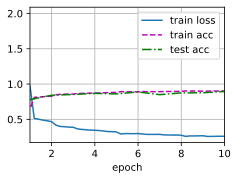

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Results

loss 0.260, train acc 0.902, test acc 0.894

9294.8 examples/sec on cuda:0

## Now without batch norm to compare

In [6]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5),nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    nn.Sigmoid(), nn.Linear(120, 84),nn.Sigmoid(),
                    nn.Linear(84, 10))

loss 0.312, train acc 0.884, test acc 0.870
19000.7 examples/sec on cuda:0


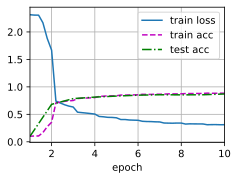

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Results
loss 0.312, train acc 0.884, test acc 0.870

19000.7 examples/sec on cuda:0